## Imports

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, mean_absolute_percentage_error

## Caminhos utilizados no fluxo

In [20]:
input_path = '/home/murilo/workspace/tcc/tcc/python_model/database/x_test.csv'
output_path = '/home/murilo/workspace/tcc/tcc/python_model/database/y_test.csv'

model_paths = {
    'Quantizado (inteiro completo)': 'model_full_integer_quantized.tflite',
    'Quantizado (apenas pesos)': 'model_weights_only_quantized.tflite',
    'Quantizado (faixa dinâmica)': 'model_dynamic_range_quantized.tflite',
    'Quantizado (float 16)' : 'model_float16_quantized.tflite',
    'Quantizado (float32)': 'model_float32.tflite',
    'Modelo Keras' : 'python_model.h5',
}

## Base de dados para teste

In [21]:
import numpy as np
import pandas as pd

def desnormalize(value, mean, scale):
    value = value * scale + mean                        
    return np.expm1(value)

mean_sodio, scale_sodio = 2.0841135541357527, 0.54462804093762
mean_potassio, scale_potassio = 1.5888672049282762, 0.47844564993241423
mean_cloro, scale_cloro = 2.7378255142446153, 0.504330768563497

In [22]:
x_test = pd.read_csv(input_path).to_numpy()
y_test = pd.read_csv(output_path).to_numpy()

# y_test = desnormalize(y_test, mean_cloro, scale_cloro)

## Volumentria dos arquivos

In [23]:
model_sizes = {name: os.path.getsize(path) for name, path in model_paths.items()}
model_sizes

{'Quantizado (inteiro completo)': 11512,
 'Quantizado (apenas pesos)': 12184,
 'Quantizado (faixa dinâmica)': 12184,
 'Quantizado (float 16)': 20176,
 'Quantizado (float32)': 36676,
 'Modelo Keras': 137112}

In [24]:
model_sizes = {
    'Inteiro completo': 11512,
    'Apenas pesos': 12184,
    'Faixa dinâmica': 12184,
    'Float 16': 20176,
    'Float32': 36676,
    'Keras': 137112
}

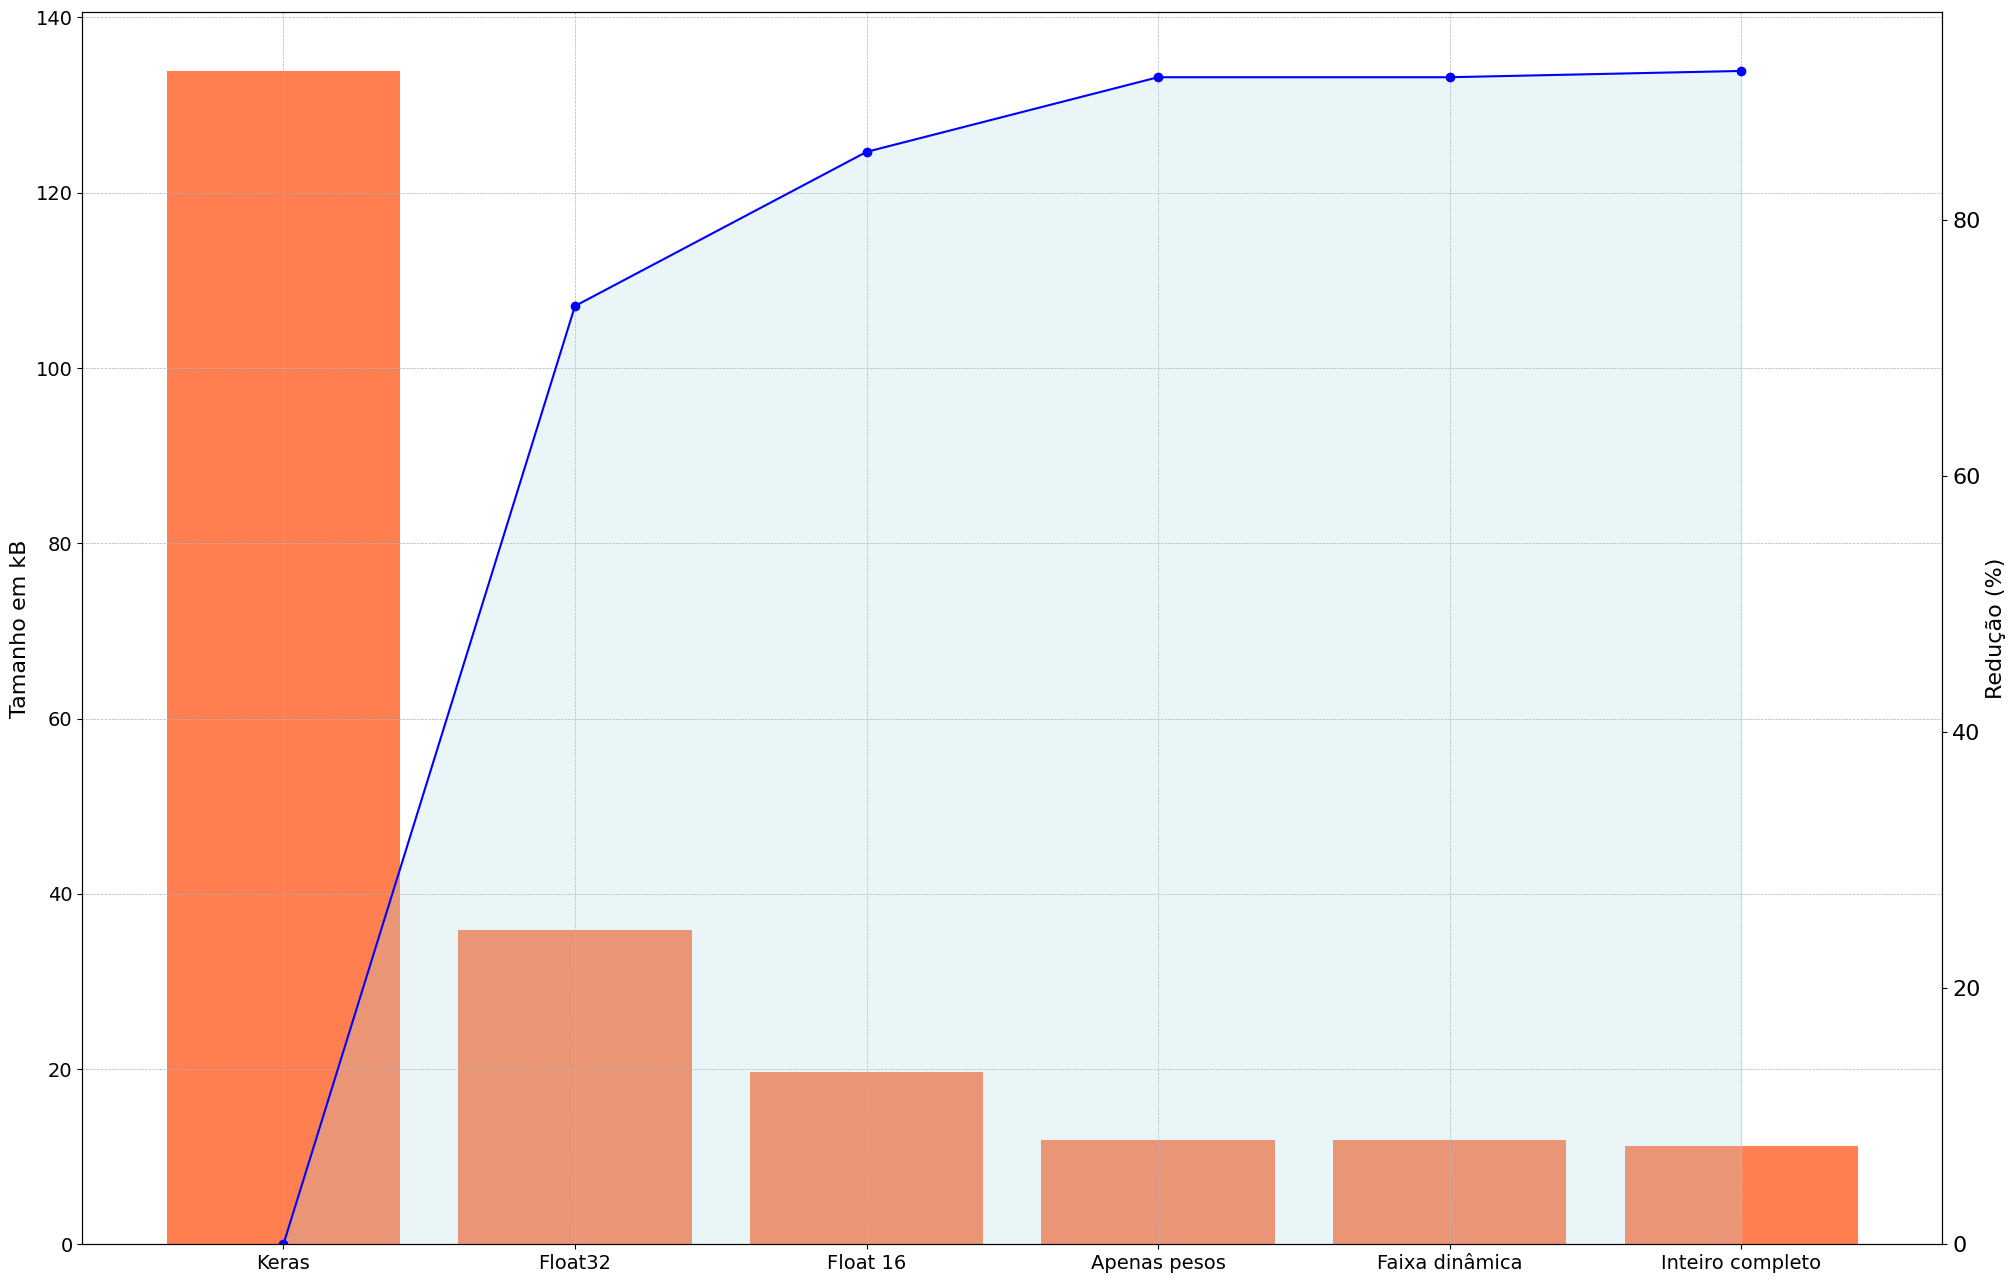

In [25]:
# Convertendo bytes para kilobytes (kB)
model_sizes_kb = {key: value / 1024 for key, value in model_sizes.items()}

# Calculando a redução percentual em relação ao modelo Keras
reduction_percentage = {model: 100 * (1 - (size / model_sizes_kb['Keras'])) for model, size in model_sizes_kb.items()}

# Ordenando os modelos pelo tamanho, do maior para o menor
sorted_models = dict(sorted(model_sizes_kb.items(), key=lambda item: item[1], reverse=True))

# Configurando o gráfico
fig, ax1 = plt.subplots(figsize=(24, 16))

# Configurando o tamanho da fonte para os eixos e títulos
plt.rcParams.update({'font.size': 14})

# Gráfico de barras para os tamanhos em kB, usando cor coral
ax1.bar(sorted_models.keys(), sorted_models.values(), color='coral', label='Tamanho em kB')
ax1.set_ylabel('Tamanho em kB', fontsize=16)
ax1.set_ylim(bottom=0)  # Garantindo que ambos os gráficos comecem em 0
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adicionando grid

# Criando um gráfico de linha sobre o mesmo eixo para a redução percentual
ax2 = ax1.twinx()
ax2.plot(sorted_models.keys(), [reduction_percentage[model] for model in sorted_models.keys()], 'b-o', label='Redução (%)')
ax2.fill_between(sorted_models.keys(), [reduction_percentage[model] for model in sorted_models.keys()], color='lightblue', alpha=0.25)  # Pintando a área sob a curva
ax2.set_ylabel('Redução (%)', fontsize=16)
ax2.set_ylim(bottom=0)  # Garantindo que ambos os gráficos comecem em 0

# Ajustando o tamanho das legendas e outros textos
plt.xticks(fontsize=22)
plt.yticks(fontsize=16)

plt.show()

In [26]:
# import plotly.express as px
# import pandas as pd

# # Dados fornecidos
# model_sizes = {
#     'Modelo Keras': 133900,
#     'Quantizado (float32)': 35820,
#     'Quantizado (float 16)': 19700,
#     'Quantizado (apenas pesos)': 11900,
#     'Quantizado (faixa dinâmica)': 11900,
#     'Quantizado (média completa)': 11900
# }

# # Convertendo o dicionário para um DataFrame
# data = pd.DataFrame(list(model_sizes.items()), columns=['Model', 'Size (KB)'])
# data['Size (MB)'] = data['Size (KB)'] / 1024
# data['Reduction (%)'] = (data['Size (MB)'] / data['Size (MB)'].iloc[0] * 100)

# # Configuração do gráfico de árvore (treemap) com as melhorias
# treemap_fig = px.treemap(
#     data,
#     path=['Model'],
#     values='Size (MB)',
#     color='Size (MB)',
#     color_continuous_scale='orrd',
#     custom_data=['Reduction (%)']
# )

# # Ajustes adicionais
# treemap_fig.update_traces(
#     marker=dict(cornerradius=8),  # Arredondar bordas
#     texttemplate="<b>%{label}<br>%{value:.2f} MB<br>%{customdata[0]:.1f}%</b>",
#     textfont_size=30,
#     textposition='middle center'
# )
# treemap_fig.update_layout(
#     coloraxis_colorbar=dict(
#         title='Size (MB)',
#         ticks="outside"
#     ),
#     width=1600,  # Largura do gráfico
#     height=700,  # Altura do gráfico
#     # margin=dict(l=0, r=0, t=0, b=0),  # Remove margens
#     # paper_bgcolor='rgba(0,0,0,0)',  # Fundo do papel transparente
#     # plot_bgcolor='rgba(0,0,0,0)',   # Fundo do gráfico transparente
#     treemapcolorway=["#000000"],     # Remover a cor de fundo da treemap
# )

# treemap_fig.show()

## Carregando os modelos

### Modelos TFlite

In [27]:
models = {
    'Quantizado (inteiro completo)': 'model_full_integer_quantized.tflite',
    'Quantizado (apenas pesos)': 'model_weights_only_quantized.tflite',
    'Quantizado (faixa dinâmica)': 'model_dynamic_range_quantized.tflite',
    'Quantizado (float 16)' : 'model_float16_quantized.tflite',
    'Quantizado (float32)': 'model_float32.tflite',
}

interpreters = {}
for key, path in models.items():
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    interpreters[key] = interpreter

### Modelo Keras

In [28]:
interpreters['Keras'] = tf.keras.models.load_model("python_model.h5")

2024-08-12 14:39:09.671824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-08-12 14:39:09.671846: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-12 14:39:09.671857: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (murilo): /proc/driver/nvidia/version does not exist
2024-08-12 14:39:09.672551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
interpreters

{'Quantizado (inteiro completo)': <tensorflow.lite.python.interpreter.Interpreter at 0x771aab4040a0>,
 'Quantizado (apenas pesos)': <tensorflow.lite.python.interpreter.Interpreter at 0x771aab404c10>,
 'Quantizado (faixa dinâmica)': <tensorflow.lite.python.interpreter.Interpreter at 0x771aab404b80>,
 'Quantizado (float 16)': <tensorflow.lite.python.interpreter.Interpreter at 0x771aab404af0>,
 'Quantizado (float32)': <tensorflow.lite.python.interpreter.Interpreter at 0x771aab406800>,
 'Keras': <keras.engine.sequential.Sequential at 0x771aabe82d70>}

## Tempo de execução

In [30]:
def predict_tflite(model, test_data):
    input_details = model.get_input_details()
    output_details = model.get_output_details()
    predictions = []

    input_type = input_details[0]['dtype']

    for example in test_data:
        test_example = np.expand_dims(example, axis=0).astype(input_type)
        model.set_tensor(input_details[0]['index'], test_example)
        model.invoke()
        output_data = model.get_tensor(output_details[0]['index'])
        predictions.append(output_data)
        
    return np.array(predictions)

inference_times = {name: [] for name in interpreters}
inferences = {name: [] for name in interpreters}

for name, model in interpreters.items():
    for _ in range(100):
        start_time = time.time()
        if 'Quantizado' in name:
            predictions = predict_tflite(model, x_test)
        else:
            predictions = model.predict(x_test)
        end_time = time.time()
        inference_times[name].append(end_time - start_time)

2/2 [==============================] - 0s 2ms/step


In [31]:
for name, times in inference_times.items():
    print(f"{name}:")
    print(f"  Média do Tempo de Inferência: {np.mean(times):.4f} segundos")
    print(f"  Mediana do Tempo de Inferência: {np.median(times):.4f} segundos")
    print(f"  Desvio Padrão: {np.std(times):.4f} segundos")
    print(f"  Máximo: {np.max(times):.4f} segundos")
    print(f"  Mínimo: {np.min(times):.4f} segundos")
    print()

Quantizado (inteiro completo):
  Média do Tempo de Inferência: 0.0006 segundos
  Mediana do Tempo de Inferência: 0.0006 segundos
  Desvio Padrão: 0.0002 segundos
  Máximo: 0.0016 segundos
  Mínimo: 0.0005 segundos

Quantizado (apenas pesos):
  Média do Tempo de Inferência: 0.0003 segundos
  Mediana do Tempo de Inferência: 0.0003 segundos
  Desvio Padrão: 0.0000 segundos
  Máximo: 0.0005 segundos
  Mínimo: 0.0003 segundos

Quantizado (faixa dinâmica):
  Média do Tempo de Inferência: 0.0003 segundos
  Mediana do Tempo de Inferência: 0.0003 segundos
  Desvio Padrão: 0.0000 segundos
  Máximo: 0.0006 segundos
  Mínimo: 0.0003 segundos

Quantizado (float 16):
  Média do Tempo de Inferência: 0.0003 segundos
  Mediana do Tempo de Inferência: 0.0003 segundos
  Desvio Padrão: 0.0001 segundos
  Máximo: 0.0006 segundos
  Mínimo: 0.0003 segundos

Quantizado (float32):
  Média do Tempo de Inferência: 0.0003 segundos
  Mediana do Tempo de Inferência: 0.0003 segundos
  Desvio Padrão: 0.0000 segundos
 

## Métricas de erro

In [32]:
def predict_tflite(model, test_data):
    input_details = model.get_input_details()
    output_details = model.get_output_details()
    predictions = []

    input_type = input_details[0]['dtype']
    
    for example in test_data:
        test_example = np.expand_dims(example, axis=0).astype(input_type)
        model.set_tensor(input_details[0]['index'], test_example)
        model.invoke()
        output_data = model.get_tensor(output_details[0]['index'])
        predictions.append(output_data[0][0])
    return np.array(predictions)

predictions_dict = {}
for name, model in interpreters.items():
    if 'Quantizado' in name:
        predictions_dict[name] = predict_tflite(model, x_test)
    else:
        predictions_dict[name] = model.predict(x_test).flatten()

2/2 [==============================] - 0s 2ms/step


In [33]:
metrics_dict = {}
for name, predictions in predictions_dict.items():
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    medae = median_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)

    metrics_dict[name] = {
        'MSE': mse,
        'RMSE': rmse, 
        'MAE': mae,
        'R2': r2,
        'MEDAE': medae,
        'MAPE': mape
    }

In [34]:
for name, metrics in metrics_dict.items():
    print(f"Resultados para o modelo {name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.5f}")
    print()

Resultados para o modelo Quantizado (inteiro completo):
  MSE: 49.06355
  RMSE: 7.00454
  MAE: 6.98162
  R2: -52.48337
  MEDAE: 6.95142
  MAPE: 25.33408

Resultados para o modelo Quantizado (apenas pesos):
  MSE: 0.03422
  RMSE: 0.18498
  MAE: 0.13312
  R2: 0.96270
  MEDAE: 0.09979
  MAPE: 0.39127

Resultados para o modelo Quantizado (faixa dinâmica):
  MSE: 0.03422
  RMSE: 0.18498
  MAE: 0.13312
  R2: 0.96270
  MEDAE: 0.09979
  MAPE: 0.39127

Resultados para o modelo Quantizado (float 16):
  MSE: 0.03407
  RMSE: 0.18458
  MAE: 0.13253
  R2: 0.96286
  MEDAE: 0.09860
  MAPE: 0.38685

Resultados para o modelo Quantizado (float32):
  MSE: 0.03407
  RMSE: 0.18458
  MAE: 0.13254
  R2: 0.96286
  MEDAE: 0.09869
  MAPE: 0.38704

Resultados para o modelo Keras:
  MSE: 0.03407
  RMSE: 0.18458
  MAE: 0.13254
  R2: 0.96286
  MEDAE: 0.09869
  MAPE: 0.38704



## Precisao dos modelos

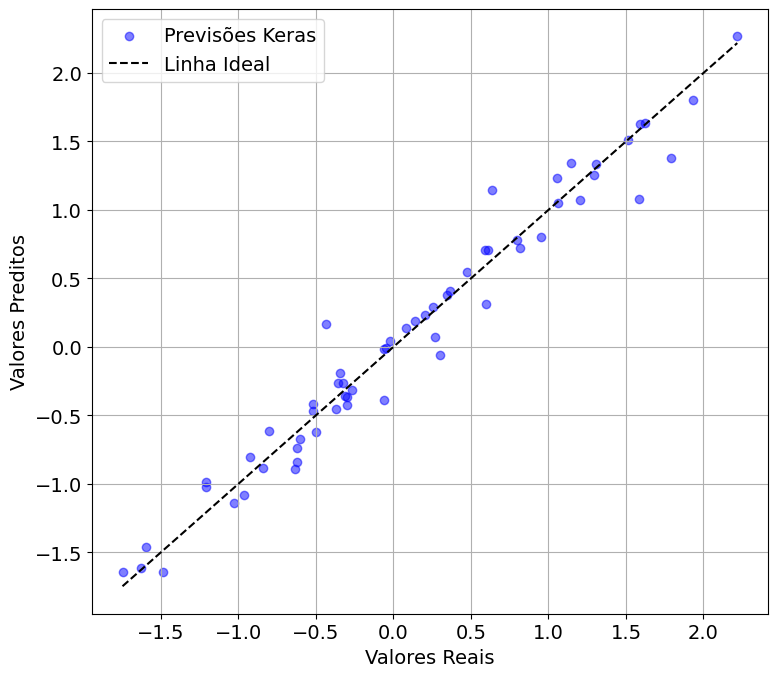

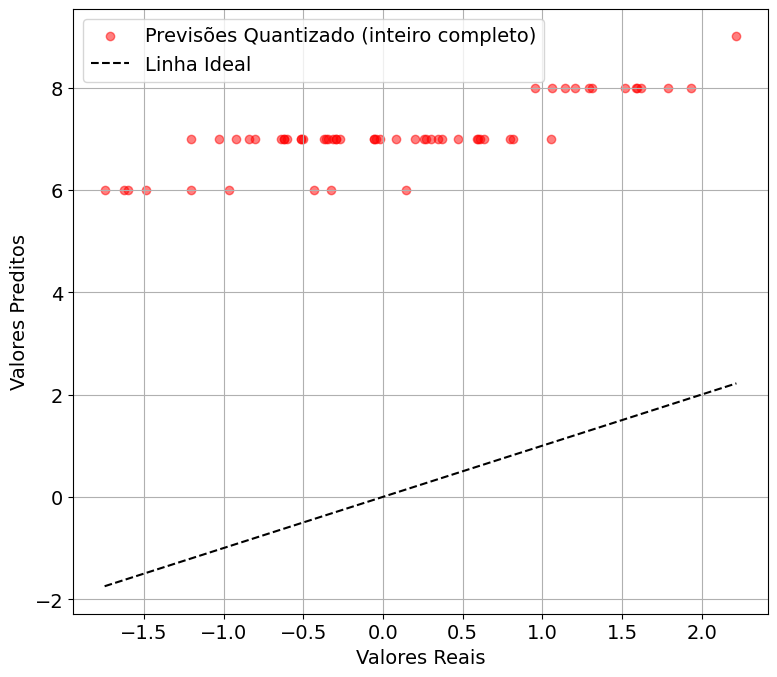

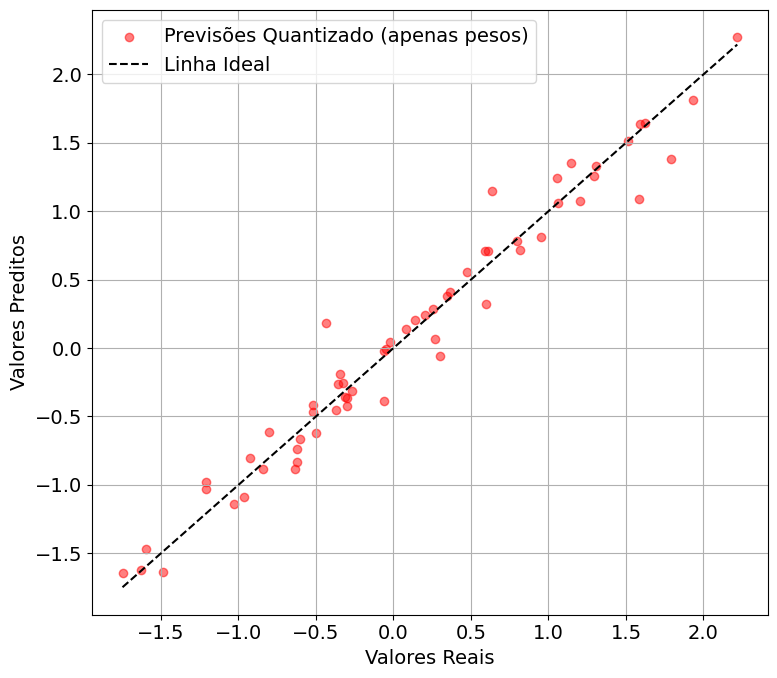

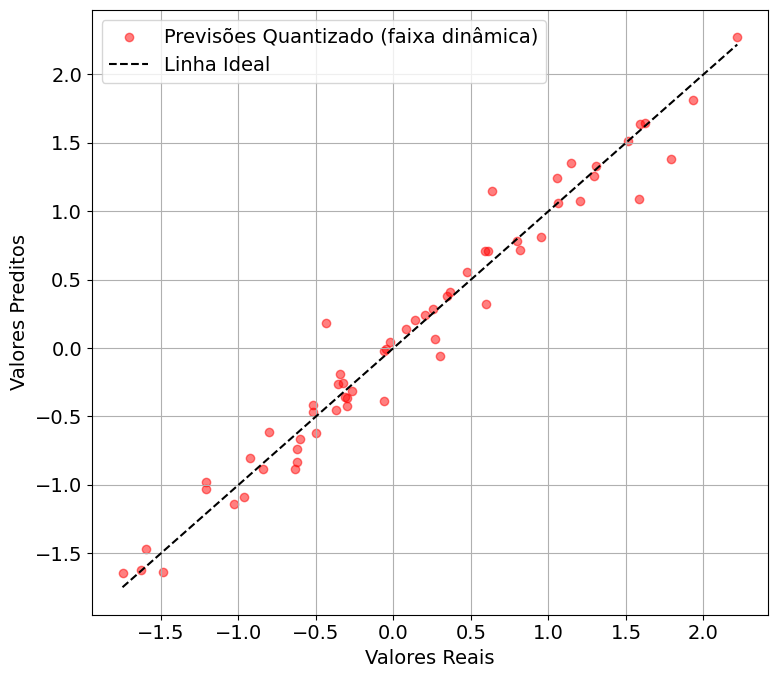

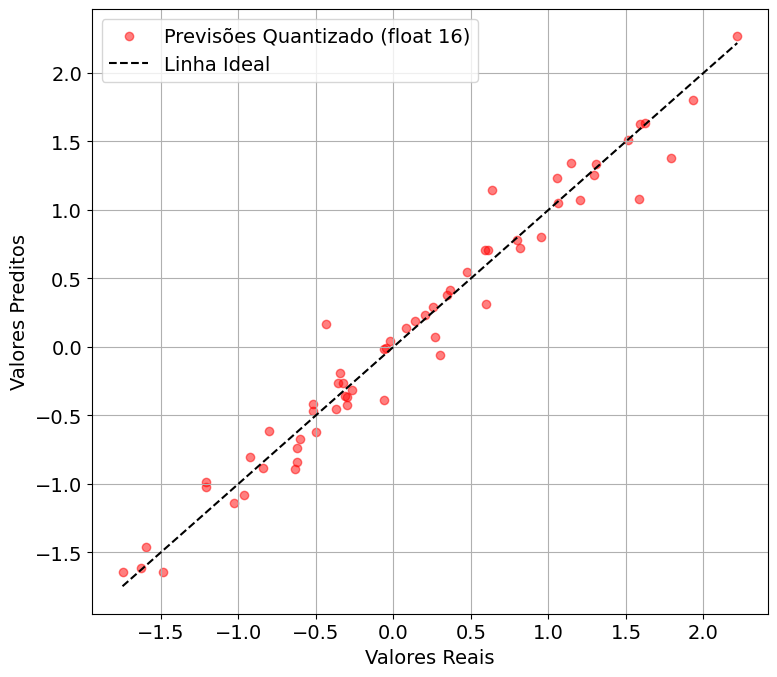

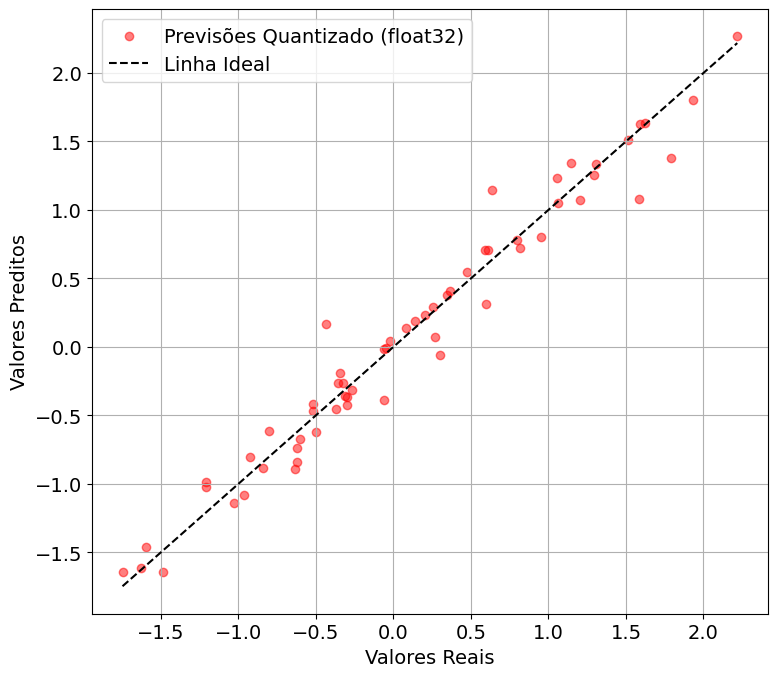

In [42]:
# Supondo que 'predictions_dict' e 'y_test' estejam definidos
model_names = [name for name in predictions_dict if 'Quantizado' in name]

# Gráfico para o modelo Keras primeiro
plt.figure(figsize=(8, 7))
plt.scatter(y_test, predictions_dict['Keras'], color='blue', alpha=0.5, label='Previsões Keras')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Linha Ideal')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Agora, gerar gráficos para cada modelo quantizado, individualmente
for name in model_names:
    plt.figure(figsize=(8, 7))
    plt.scatter(y_test, predictions_dict[name], color='red', alpha=0.5, label=f'Previsões {name}')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Linha Ideal')
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Preditos')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


### O modelo quantizado utilizado float 32 manteve a precisão mais próxima do modelo real.

## Detalhe do modelo Float 32

In [36]:
model = interpreters['Quantizado (float32)']

input_details = model.get_input_details()
print("Detalhes do Tensor de Entrada:", input_details)

output_details = model.get_output_details()
print("Detalhes do Tensor de Saída:", output_details)

Detalhes do Tensor de Entrada: [{'name': 'serving_default_dense_3_input:0', 'index': 0, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Detalhes do Tensor de Saída: [{'name': 'StatefulPartitionedCall:0', 'index': 9, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


## Criação do array de bytes para o Embarque na ESP32

In [37]:
tflite_model_file = 'model_float32.tflite'

# Conteúdo do arquivo model.h
header_content = """
#ifndef MODEL_H_
#define MODEL_H_

extern const unsigned char model[];
extern const int model_len;

#endif  // MODEL_H_
"""

# Escreve o conteúdo no arquivo model.h
with open("model.h", "w") as file:
    file.write(header_content.strip())

with open(tflite_model_file, 'rb') as f:
    tflite_model_content = f.read()

with open("model.cc", "w") as f:
    f.write("const unsigned char model[] = {\n    ")
    for i, byte in enumerate(tflite_model_content):
        f.write(f"0x{byte:02x}, ")
        if (i + 1) % 12 == 0:
            f.write("\n    ")
    f.write("\n};\n")
    f.write(f"const int model_len = {len(tflite_model_content)};")